In [1]:
using NPZ
using Plots
using PaddedViews
using ProgressMeter
using LinearAlgebra

# Wczytanie danych

In [2]:
train_dict = npzread("KMNIST/kmnist-train-imgs.npz")
train_labels = npzread("KMNIST/kmnist-train-labels.npz")
test_dict = npzread("KMNIST/kmnist-test-imgs.npz")
test_labels = npzread("KMNIST/kmnist-test-labels.npz");

In [3]:
labels = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"];

In [4]:
train_y = convert(Vector{Int64}, train_labels["arr_0"])
test_y = convert(Vector{Int64}, test_labels["arr_0"])

train_x = convert(Array{Float32}, train_dict["arr_0"])/255
train_x = permutedims(train_x, (2,3,1))
train_x = reshape(train_x, (28,28,1,60000))

test_x = convert(Array{Float32}, test_dict["arr_0"])/255
test_x = permutedims(test_x, (2,3,1))
test_x = reshape(test_x, (28,28,1,10000));

println("Train images:\t", size(train_x), "\t\t labels: ", size(train_y))
println("Test images:\t", size(test_x), "\t\t labels: ", size(test_y))

Train images:	(28, 28, 1, 60000)		 labels: (60000,)
Test images:	(28, 28, 1, 10000)		 labels: (10000,)


# Graf obliczeniowy -- węzły

In [5]:
abstract type Node end
abstract type Operator <: Node end

mutable struct Variable{N} <: Node
    name::String
    output::Array{Float64, N}
    gradient::Array{Float64, N}
    v₁::Array{Float64, N}
    v₂::Array{Float64, N}
    Variable(N, output; name = "?") = new{N}(name, output, zeros(size(output)), zeros(size(output)), zeros(size(output)))
end

mutable struct NodeOperator{F} <: Operator
    name::String
    inputs
    output
    gradient
    NodeOperator(fun, inputs...; name = "?") = new{typeof(fun)}(name, inputs, [], [])
end

In [6]:
import Base: show, summary
show(io::IO, x::NodeOperator{F}) where {F} = print(io, "op ", "(", F, ")");
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 391 methods)

# Graf obliczeniowy -- funkcje

### Tworzenie grafu

In [7]:
function visit(node::Node, visited::Set, order::Vector)
    if node ∉ visited
        push!(visited, node)
        push!(order, node)
    end
end

function visit(node::Operator, visited::Set, order::Vector)
    if node ∉ visited
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(visited, node)
        push!(order, node)
    end
end


function create_graph(root::Node)
    visited = Set()
    order = Vector()
    visit(root, visited, order)
    return order
end

create_graph (generic function with 1 method)

### Przejście w przód z zerowaniem gradientu

In [8]:
# zero_gradient!(node::Variable) = fill!(node.gradient, 0)
# zero_gradient!(node::Operator) = fill!(node.gradient, 0)

zero_gradient!(node::Variable) = fill!(node.gradient, 0)
zero_gradient!(node::Operator) = node.gradient = []

compute!(node::Variable) = nothing
compute!(node::Operator) = node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        zero_gradient!(node)
    end
    
    return last(order).output
end    

forward! (generic function with 1 method)

### Przejście w tył

In [9]:
update!(node::Node, gradient) = if isempty(node.gradient)
    node.gradient = gradient else node.gradient += gradient
end

function backward!(order::Vector; seed = 1.0)
    result = last(order)
    result.gradient = seed
    
    for node in reverse(order)
        backward!(node)
    end
end

backward!(node::Variable) = nothing

function backward!(node::Operator)
    gradients = backward(node, [input.output for input in node.inputs]..., node.gradient)
    for (input, gradient) in zip(node.inputs, gradients)
        update!(input, gradient)
    end
end

backward! (generic function with 3 methods)

# Sieć i warstwy

### Definicja struktur parametrów

In [10]:
mutable struct ConvParams
    kernels::Variable
    bias::Variable
end

mutable struct DenseParams
    weights::Variable
    bias::Variable
end

mutable struct CNNParams
    conv1::ConvParams
    conv2::ConvParams
    dense1::DenseParams
    dense2::DenseParams
end

### Warstwa konwolucyjna

In [11]:
conv_layer(x::Node, k::Node, b::Node) = NodeOperator(conv_layer, name="conv", x, k, b)

forward(::NodeOperator{typeof(conv_layer)}, x, k, b) = let
    x_size = size(x)
    k_size = size(k)
    no_k = floor(Int, sqrt(k_size[2])) - 1
    x̂_size = x_size[1] - 4
    x_vectorized = zeros(k_size[2], x̂_size^2, x_size[3])
    no_patch = 1
    for c in 1:x̂_size, r in 1:x̂_size
        x_vectorized[:, no_patch, :] = reshape(x[r:(r+no_k), c:(c+no_k), :], (k_size[2], 1, x_size[3]))
        no_patch += 1
    end
    x̂_vectorized = zeros(k_size[1], x̂_size^2)

    for i in 1:x_size[3]
        x̂_vectorized[:, :] += k * x_vectorized[:, :, i]
    end
    
    x̂_vectorized .+= b

    x̂ = zeros(x̂_size, x̂_size, k_size[1])
    for i in 1:k_size[1]
        x̂[:, :, i] = reshape(x̂_vectorized[i, :], (x̂_size, x̂_size))
    end
    
    return x̂
end

backward(::NodeOperator{typeof(conv_layer)}, x, k, b, g) = let
    x_size = size(x)
    k_size = size(k)
    no_k = floor(Int, sqrt(k_size[2])) - 1
    x̂_size = x_size[1] - 4
    x_vectorized = zeros(k_size[2], x̂_size^2, x_size[3])
    no_patch = 1
    for c in 1:x̂_size, r in 1:x̂_size
        x_vectorized[:,no_patch, :] = reshape(x[r:(r+no_k), c:(c+no_k), :], (k_size[2], 1, x_size[3]))
        no_patch += 1
    end
    
    g_vectorized = reshape(g, size(g)[1]^2, size(g)[3])
    dk = zeros(k_size)
    
    dk = g_vectorized' * sum(x_vectorized, dims=3)[:,:,1]'
    
    db = sum(g_vectorized', dims=1)
    
    g_size = size(g)
    g_padded = PaddedView(0, g, (1:(g_size[1]+8), 1:(g_size[1]+8), 1:g_size[3]), (5:(g_size[1]+4), 5:(g_size[1]+4), 1:g_size[3]))
    g_pad_vect = zeros(k_size[2], (g_size[1]+4)^2, g_size[3])
    no_patch = 1
    for c in 1:(g_size[1]+4), r in 1:(g_size[1]+4)
        g_pad_vect[:, no_patch, :] = reshape(g_padded[r:(r+no_k), c:(c+no_k), :], (k_size[2], 1, g_size[3]))
        no_patch += 1
    end
    k_reversed = reverse(k, dims=2)
    
    dx = zeros(g_size[3], (g_size[1]+4)^2)

    for i in 1:g_size[3]
        dx[:, :] += k_reversed * g_pad_vect[:, :, i]
    end
    
    dx = sum(dx, dims=1)

    dx = repeat(reshape(dx, (x_size[1], x_size[1])), 1, 1, x_size[3])
    
    return tuple(dx, dk, db)
end

backward (generic function with 1 method)

### Warstwa maxpool

In [12]:
maxpool_layer(x::Node) = NodeOperator(maxpool_layer, name="maxpool", x)

forward(::NodeOperator{typeof(maxpool_layer)}, x) = let
    n = floor(Int, size(x)[1]/2) # new size
    x̂ = zeros(n, n, size(x)[3])
    s = 2 # stride
    
    for r in 1:n, c in 1:n
        x̂[r, c, :] = maximum(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2))
    end
    
    return x̂
end

backward(::NodeOperator{typeof(maxpool_layer)}, x, g) = let
    n = floor(Int, size(x)[1]/2) # new size
    s = 2 # stride
    x̂ = zeros(size(x))
    
    for r in 1:n, c in 1:n
        idx = argmax(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2))
        @views x̂[(r*s-1):(r*s), (c*s-1):(c*s), :][idx] = g[r, c, :]
    end
    return tuple(x̂)
end

backward (generic function with 2 methods)

### Warstwa flatten

In [13]:
flatten(x::Node) = NodeOperator(flatten, name="flatten", x)

forward(::NodeOperator{typeof(flatten)}, x) = let
    return reshape(x, size(x)[1]*size(x)[2]*size(x)[3])
end

backward(::NodeOperator{typeof(flatten)}, x, g) = let
    return tuple(reshape(g, size(x)))
end

backward (generic function with 3 methods)

### Warstwa gęsta

In [14]:
dense_layer(x::Node, w::Node, b::Node) = NodeOperator(dense_layer, name="dense", x, w, b)

forward(::NodeOperator{typeof(dense_layer)}, x, w, b) = let
    return w * x + b
end

backward(::NodeOperator{typeof(dense_layer)}, x, w, b, g) = let
    return tuple(w' * g, g * x', g)
end

backward (generic function with 4 methods)

### ReLU

In [15]:
relu(x::Node) = NodeOperator(relu, name="relu", x)

forward(::NodeOperator{typeof(relu)}, x) = let
    return max.(x, 0)
end

backward(::NodeOperator{typeof(relu)}, x, g) = let
    id_max = findall(a -> a > 0, x)
    x̂ = zeros(Float64, size(x))
    x̂[id_max] = g[id_max]
    return tuple(x̂)
end

backward (generic function with 5 methods)

### Softmax

In [16]:
softmax(x::Node) = NodeOperator(softmax, name="softmax", x)

forward(::NodeOperator{typeof(softmax)}, x) = let
    return exp.(x) ./ sum(exp.(x))
end

backward(node::NodeOperator{typeof(softmax)}, x, g) = let
    y = node.output
    J = diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 6 methods)

### Funkcja straty -- cross entropy loss

In [17]:
cross_entropy_loss(ŷ::Node, y::Node) = NodeOperator(cross_entropy_loss, name="cross_entropy_loss", ŷ, y)

forward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y) = let
    return -log(ŷ[floor(Int, y[1]+1)])
end

backward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y, g) = let
    x = zeros(10)
    id = floor(Int, y[1]) + 1
    x[id] = -1 / ŷ[id] * g
    return tuple(x, [0.0])
end

backward (generic function with 7 methods)

## Struktura sieci

In [18]:
function my_cnn(x::Variable, y::Variable, params::CNNParams)
    x̂ = conv_layer(x, params.conv1.kernels, params.conv1.bias)
    x̂ = relu(x̂)
    x̂ = maxpool_layer(x̂)
    x̂ = conv_layer(x̂, params.conv2.kernels, params.conv2.bias)
    x̂ = relu(x̂)
    x̂ = maxpool_layer(x̂)
    
    x̂ = flatten(x̂)
    
    x̂ = dense_layer(x̂, params.dense1.weights, params.dense1.bias)
    x̂ = dense_layer(x̂, params.dense2.weights, params.dense2.bias)
    
    ŷ = softmax(x̂)
    
    loss = cross_entropy_loss(ŷ, y)
    
    return create_graph(loss)
end

my_cnn (generic function with 1 method)

### Inicjalizacja wag

In [19]:
function he_weights_init(prev, shape...)
    std = sqrt(2.0/prev)
    weights = rand(Float64, shape) .*2 .-1
    return weights .* std
end

he_weights_init (generic function with 1 method)

### Optymalizator -- ADAM

In [20]:
mutable struct Adam
    α::Float64
    ε::Float64
    m₁::Float64
    m₂::Float64
    k::Int64
    Adam(α=0.001, m₁=0.9, m₂=0.999, ε=1e-8) = new(α, ε, m₁, m₂, 1)
end

In [21]:
function update_weights!(graph, M::Adam)
    m₁, m₂ =  M.m₁, M.m₂
    α, ε, k = M.α, M.ε, M.k
    for node in graph
        if typeof(node) == Variable{1} || typeof(node) == Variable{2} || typeof(node) == Variable{3}
            g = node.gradient
            v₁ = node.v₁
            v₂ = node.v₂
            v₁[:] = m₁*v₁ + (1.0 - m₁) * g
            v₂[:] = m₂*v₂ + (1.0 - m₂) * g .* g
            
            v̂₁ = v₁ ./ (1.0 - m₁^k)
            v̂₂ = v₂ ./ (1.0 - m₂^k)
    
            node.output -= α*v̂₁ ./ (sqrt.(v̂₂) .+ ε)
        end
    end
    M.k = k += 1
end

update_weights! (generic function with 1 method)

### Inicjalizacja parametrów sieci

In [37]:
conv1 = ConvParams(
    Variable(2, he_weights_init(28*28, 20,25), name="k1"),
    Variable(2, zeros(1,24*24), name="b1")
)
conv2 = ConvParams(
    Variable(2, he_weights_init(12*12*20, 50,25), name="k2"),
    Variable(2, zeros(1,8*8), name="b2")
)
dense1 = DenseParams(
    Variable(2, he_weights_init(4*4*50, 500,800), name="w3"),
    Variable(1, zeros(500), name="b3")
)
dense2 = DenseParams(
    Variable(2, he_weights_init(500, 10,500), name="w4"),
    Variable(1, zeros(10), name="b4")
)

cnn_params = CNNParams(conv1, conv2, dense1, dense2);

In [23]:
function validate(x, y, graph, e)
    correct_val = 0
    correct_class = zeros(10)
    
    for i in 1:no_val
        x.output = val_x[:,:,:,i]
        y.output = [val_y[i]]
        forward!(graph)
        pred = argmax(graph[19].output)
        if pred == (val_y[i] + 1)
            correct_val += 1
            correct_class[pred] += 1
        end
    end
    
    acc_val = correct_val/no_val
    acc_class[:, e] = correct_class ./ count_class
    
    return (acc_val, acc_class)
end

validate (generic function with 1 method)

In [38]:
no_train = 100
epochs = 10

ids = rand(1:60000, no_train)
data_x = train_x[:,:,:,ids]
data_y = train_y[ids]

no_val = 100
ids_val = rand(1:10000, no_val)
val_x = test_x[:,:,:,ids_val]
val_y = test_y[ids_val]


loss = 0
losses = zeros(epochs)
count_class = [count(==(i), val_y) for i in 0:9]
acc = zeros(epochs)
acc_class = zeros(10, epochs)
acc_val = 0
correct_val = 0
correct = 0

adam = Adam()

x = Variable(3, data_x[:,:,:,1], name="x")
y = Variable(1, [data_y[1]], name="y")
graph = my_cnn(x, y, cnn_params)

for e in 1:epochs
    loss = 0
    correct = 0
    
    for i in 1:no_train
        x.output = data_x[:,:,:,i]
        y.output = [data_y[i]]
        
        loss += forward!(graph)
        pred = argmax(graph[19].output)
        if pred == (data_y[i] + 1)
            correct += 1
        end
        
        backward!(graph)
        
        update_weights!(graph, adam)
    end
    
    losses[e] = loss/no_train
    acc[e] = correct/no_train
    acc_val, acc_class = validate(x, y, graph, e)
    
    println("Epoch: ", e, "\tAverage loss: ", round(losses[e], digits=3), "\tAverage acc: ", round(acc[e],digits=3), "\tAverage val acc: ", round(acc_val, digits=3))
end

println(round.(acc_class[:, epochs], digits=3))

Epoch: 1	Average loss: 2.138	Average acc: 0.26	Average val acc: 0.37
Epoch: 2	Average loss: 1.343	Average acc: 0.54	Average val acc: 0.44
Epoch: 3	Average loss: 0.79	Average acc: 0.71	Average val acc: 0.49
Epoch: 4	Average loss: 0.577	Average acc: 0.79	Average val acc: 0.47
Epoch: 5	Average loss: 0.471	Average acc: 0.85	Average val acc: 0.42
Epoch: 6	Average loss: 0.368	Average acc: 0.86	Average val acc: 0.43
Epoch: 7	Average loss: 0.29	Average acc: 0.91	Average val acc: 0.41
Epoch: 8	Average loss: 0.209	Average acc: 0.89	Average val acc: 0.41
Epoch: 9	Average loss: 0.571	Average acc: 0.86	Average val acc: 0.48
Epoch: 10	Average loss: 0.207	Average acc: 0.91	Average val acc: 0.47
[0.545, 0.353, 0.4, 0.5, 0.25, 0.545, 0.571, 0.385, 0.5, 0.556]


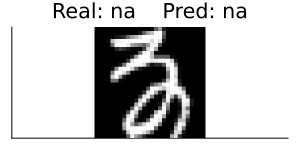

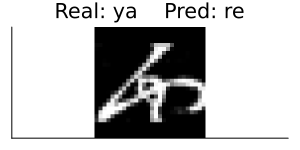

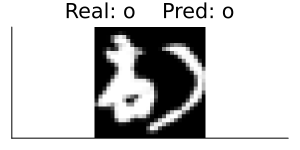

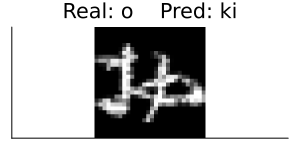

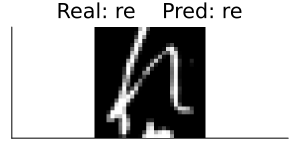

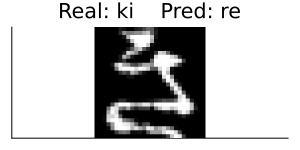

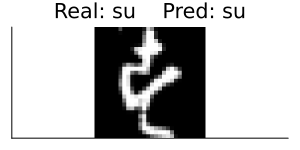

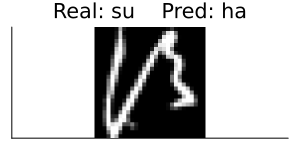

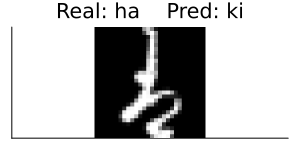

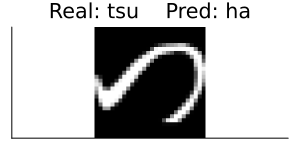

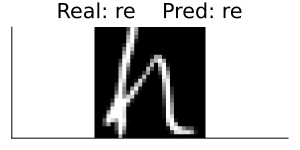

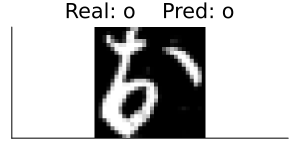

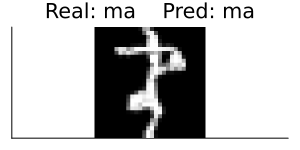

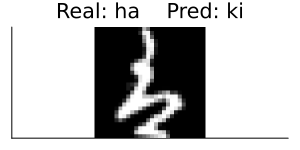

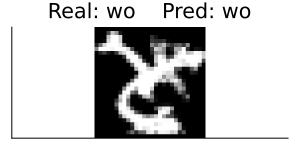

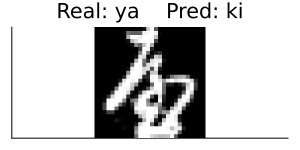

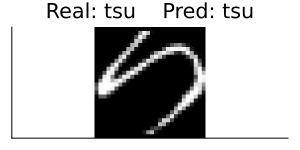

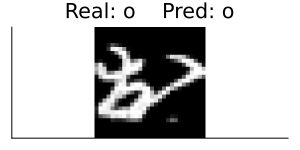

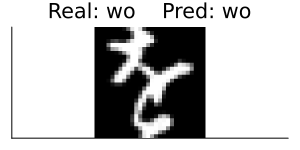

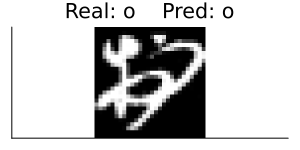

In [39]:
for i in 1:20
    id = rand(1:60000, 1)[1]
    img = train_x[:,:,:,id]
    img_label = [train_y[id]]
    x = Variable(3, img, name="x")
    y = Variable(1, img_label, name="y")
    graph = my_cnn(x, y, cnn_params)
    forward!(graph)
    real_label = labels[img_label[1]+1]
    pred = labels[argmax(graph[19].output)]
    display(plot(Gray.(img[:,:,1]), axis=nothing, size=(300,150), title="Real: $real_label    Pred: $pred"))
end